In [187]:
%matplotlib inline
import gurobipy as grb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [188]:
list_of_bookmakers = ['b365', 'bwin']

In [189]:
def kelly_criterion(p, odd):
    return p - (1 - p) / (odd - 1)

In [190]:
def solve(total_budget, single_bet_budget, data, list_of_bookmakers):
    """
    Main solver to solve the betting strategy problem
    """
    
    
    ###################################################################
    ### Step 1: Config parameters: p_games, bookmakers, kelly, etc. ###
    ###################################################################
    
    # p_games: probability of each game result
    p_games = data[['Home Win', 'Home Draw', 'Home Lost']]
    num_of_games = p_games.shape[0]

    # Bookmakers
    num_of_results = 3
    all_bookmaker_odds = []
    for bookmaker in list_of_bookmakers:
        bookmaker_odds = data[[bookmaker + 'H', bookmaker + 'D', bookmaker + 'A']]
        all_bookmaker_odds.append(bookmaker_odds)
        
    b365 = data[['b365H', 'b365D', 'b365A']]
    bwin = data[['bwinH', 'bwinD', 'bwinA']]
    bookmakers = [b365, bwin]
    num_of_bookmakers = len(list_of_bookmakers)
    head_to_head = data['Home vs Away']
    first_level_idx = []
    for bookmaker in list_of_bookmakers:
        first_level_idx += [bookmaker] * num_of_games   
    second_level_idx = list(head_to_head) * num_of_bookmakers
    
    index = [first_level_idx, second_level_idx]
    bookmakers = pd.DataFrame(np.concatenate([bookmaker_odds.values for bookmaker_odds in all_bookmaker_odds]), 
                              index=index, columns=['Home', 'Draw', 'Away'])

    # Extract the values as numpy arraies from data frames. 
    p_games_val = p_games.values
    bookmakers_val = np.zeros((num_of_games, num_of_results, num_of_bookmakers))    
    for i in np.arange(num_of_bookmakers):
        bookmakers_val[:, :, i] = bookmakers.ix[list_of_bookmakers[i]].values
           
    # Kelly, bookmakers, and probabilities of the results of each game, put into a dict
    kellies = {}
    bookmaker_row_vector = {}
    prob_row_vector = {}
    
    
    ##############################################################################
    ### Step 2: Use Gurobi solver, model the optimization problem and solve it ###
    ##############################################################################
    
    # Create Gurobi Model
    m = grb.Model('betting strategy')
    
    # Create decision variables for the betting strategy, which are binary vars
    # either bet this one or not. The price to bet is the corresponding kelly criteria value
    # Also populate the parameters here
    bet = {}   # bianry decision var
    bet_idx = 0
    n = 0
    for i in np.arange(num_of_games):
        for j in np.arange(num_of_bookmakers):
            for k in np.arange(num_of_results):
                p = p_games_val[i, k]
                odd = bookmakers_val[i, k, j]
                kelly = kelly_criterion(p, odd)
                bet_name = head_to_head[i] + ',' + p_games.columns[k] + ',' + list_of_bookmakers[j]
                kellies[bet_name] = kelly
                bookmaker_row_vector[bet_name] = odd
                prob_row_vector[bet_name] = p                
                bet[bet_name] = m.addVar(vtype = grb.GRB.BINARY, name=bet_name)
                              
                bet_idx += 1
                
    m.update()
    
    # Add constraint: bet_i * kelly * single_bet_budget >= 0, otherwise we don't bet on it
    for bet_name in bet.keys():
        m.addConstr(bet[bet_name] * kellies[bet_name] * single_bet_budget >= 0, 
                    'we must bet on positive kelly games: ' + bet_name )
        
    # Add constraint: Total_bet <= total_budget
    m.addConstr(
        grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget for bet_name in bet.keys()) <= total_budget, 
        'Total_bet <= total_budget')
    
    # Add objective function: maximize profit
    # we need to experiment with different obj functions here. This obj function tries to maximize 
    # the total potential profit
#     m.setObjective(
#         grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget * (bookmaker_row_vector[bet_name] - 1) 
#                      for bet_name in bet.keys()), grb.GRB.MAXIMIZE)
    
    # This obj function tries to maximize the total expected profit. It takes the probability of each potential
    # profit into acount
#     m.setObjective(
#         grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget * (bookmaker_row_vector[bet_name] - 1) 
#                      * prob_row_vector[bet_name] - bet[bet_name] * kellies[bet_name] * single_bet_budget * (1 - prob_row_vector[bet_name]) 
#                      for bet_name in bet.keys()), grb.GRB.MAXIMIZE)    
    
    # This obj function tries to maximize the weighted total expected profit and expected bet precision.
    weight_profit = 1.0
    weight_bet_precision = 1 - weight_profit
    
    expected_profit = grb.quicksum(bet[bet_name] * kellies[bet_name] * single_bet_budget                                   
                                   * (bookmaker_row_vector[bet_name] - 1) * prob_row_vector[bet_name] 
                                   - bet[bet_name] * kellies[bet_name] * single_bet_budget * (1 - prob_row_vector[bet_name]) 
                                   for bet_name in bet.keys())
    max_possible_profit = sum([kellies[bet_name] * single_bet_budget * (bookmaker_row_vector[bet_name] - 1)
                               for bet_name in bet.keys() if kellies[bet_name] > 0])
    
    scaled_expected_profit = expected_profit / max_possible_profit
    
    scaled_expected_bet_precision = grb.quicksum(bet[bet_name] * 
                                                 prob_row_vector[bet_name] 
                                                 for bet_name in bet.keys()) / sum(prob_row_vector[bet_name] 
                                                                                   for bet_name in bet.keys())
        
    m.setObjective(weight_profit * scaled_expected_profit + weight_bet_precision * scaled_expected_bet_precision
                   , grb.GRB.MAXIMIZE)      
    
    # solve the optimization problem
    m.params.OutputFlag = 0
    m.optimize()
    
    ###########################
    ### Step 3: Get results ###
    ###########################
    
    actual_bets = {bet_name : bet[bet_name].x * kellies[bet_name] * single_bet_budget for bet_name in bet.keys()}
    
    expected_received = sum(bet[bet_name].x * kellies[bet_name] * single_bet_budget 
                                * bookmaker_row_vector[bet_name] * prob_row_vector[bet_name]  
                                for bet_name in bet.keys())
    expected_profit = expected_received - sum(actual_bets.values())
    
    potential_received = {bet_name : bet[bet_name].x * kellies[bet_name] * single_bet_budget 
                          * bookmaker_row_vector[bet_name] for bet_name in bet.keys()}
    
    return expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector
                
    


In [191]:
def get_actual_profit(actual_bets, data, bookmaker_row_vector):
    # Game Result, pandas data frame, with index as "a vs b", and columns as "Home Win","Home Draw", "Home Lost"
    result = pd.get_dummies(data, columns=['result'])[['result_1', 'result_2', 'result_3']]
    result = result.set_index(data['Home vs Away'].values)
    result.rename(columns = {'result_1' : 'Home Win', 'result_2' : 'Home Draw', 'result_3' : 'Home Lost'}, inplace=True)
    
    actual_received = {bet_name: actual_bets[bet_name] * bookmaker_row_vector[bet_name] 
                       if result.ix[bet_name.split(',')[0], bet_name.split(',')[1]] == 1
                      else 0 for bet_name in actual_bets.keys()}
    bet_precision = {bet_name: 1 if actual_bets[bet_name] > 0 and 
                     result.ix[bet_name.split(',')[0], bet_name.split(',')[1]] == 1
                     else -1 if actual_bets[bet_name] > 0 and  
                     result.ix[bet_name.split(',')[0], bet_name.split(',')[1]] != 1 
                     else 0 for bet_name in actual_bets.keys()}
    
    import copy
    bet_precision_copy = copy.deepcopy(bet_precision) 
    for bet_name, r in bet_precision_copy.items():
        if r == 0:
            del bet_precision[bet_name]
        elif r == -1:
            bet_precision[bet_name] = 0
    
    actual_profit = sum(actual_received.values()) - sum(actual_bets.values())
    return actual_profit, bet_precision

In [192]:
l = [1,2, 3, 4, 5]
pr = {v:'yes' if v == 1 else 'no' if v == 2 or v == 3 else 'idle' for v in l}
pr

{1: 'yes', 2: 'no', 3: 'no', 4: 'idle', 5: 'idle'}

In [193]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    from matplotlib import pyplot as plt
    corr = df.corr()
    print(corr)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [194]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : [], 'bet_precision' : []}
data = pd.read_csv('../../../data/third_party_preds/betegy-121115.csv')
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 350, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit, bet_precision = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)
        result_dict['bet_precision'].append(np.mean(np.array(list(bet_precision.values()))))

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
0,85.450272,0.142857,212.703460,50,100
1,180.577403,0.400000,253.067323,75,100
2,90.716696,0.222222,278.521830,100,100
3,-97.616035,0.142857,307.920393,125,100
4,-99.999457,0.000000,330.887556,150,100


0.929292929293
                   actual_profit  bet_precision  expected_profit  \
actual_profit           1.000000       0.528871         0.769129   
bet_precision           0.528871       1.000000         0.103313   
expected_profit         0.769129       0.103313         1.000000   
single_bet_budget       0.485200      -0.089478         0.690595   
total_budget            0.432993       0.140719         0.639422   

                   single_bet_budget  total_budget  
actual_profit               0.485200      0.432993  
bet_precision              -0.089478      0.140719  
expected_profit             0.690595      0.639422  
single_bet_budget           1.000000      0.000000  
total_budget                0.000000      1.000000  


,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
418,949.477692,0.312500,1598.478085,300,950
1,180.577403,0.400000,253.067323,75,100
430,929.477692,0.333333,1621.057630,300,975
10,-99.702078,0.000000,457.370174,300,100
420,80.931628,0.215686,389.513540,50,975


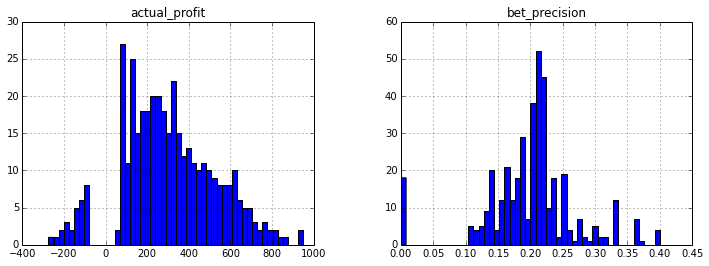

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


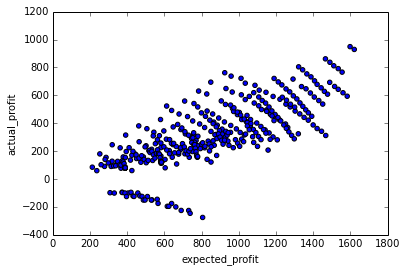

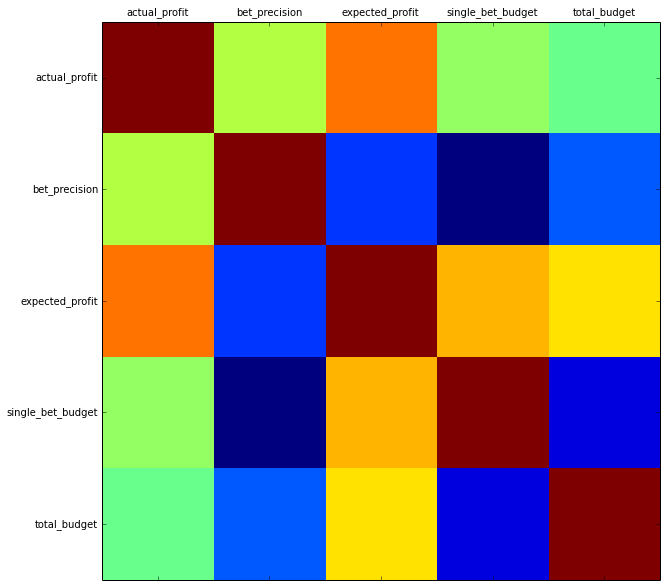

In [195]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 300]
betting_tracker_copy.hist(column=['actual_profit', 'bet_precision'], bins = 50, figsize = (12, 4))
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)
betting_tracker_copy.ix[betting_tracker_copy.idxmax(), :]

In [196]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : [], 'bet_precision' : []}
data = pd.read_csv('../../../data/third_party_preds/betegy-120415.csv')
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 350, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit, bet_precision = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)
        result_dict['bet_precision'].append(np.mean(np.array(list(bet_precision.values()))))

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
0,175.773099,0.266667,143.316153,50,100
1,164.977273,0.200000,170.010774,75,100
2,141.015368,0.125000,189.438221,100,100
3,201.312500,0.200000,206.606250,125,100
4,261.600000,0.200000,214.693500,150,100


In [197]:
betting_tracker.ix[betting_tracker.idxmax(), :]

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
406,1499.647036,0.368421,1060.840914,300,925
23,698.587500,0.666667,264.251542,325,125
431,1396.486740,0.300000,1131.073408,325,975
11,-99.325000,0.000000,216.367250,325,100
420,292.045739,0.333333,216.171884,50,975


0.987373737374
                   actual_profit  bet_precision  expected_profit  \
actual_profit           1.000000       0.491407         0.932105   
bet_precision           0.491407       1.000000         0.210950   
expected_profit         0.932105       0.210950         1.000000   
single_bet_budget       0.539357      -0.354201         0.719797   
total_budget            0.678424       0.638085         0.573546   

                   single_bet_budget  total_budget  
actual_profit               0.539357      0.678424  
bet_precision              -0.354201      0.638085  
expected_profit             0.719797      0.573546  
single_bet_budget           1.000000      0.000000  
total_budget                0.000000      1.000000  


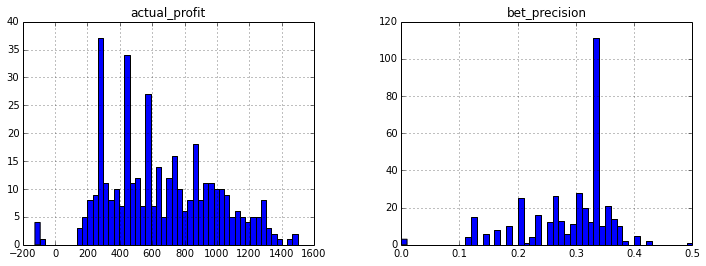

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


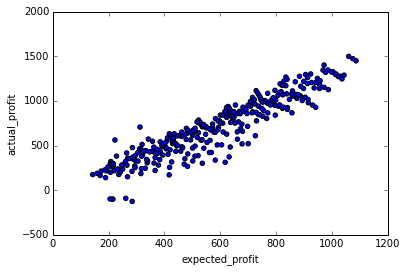

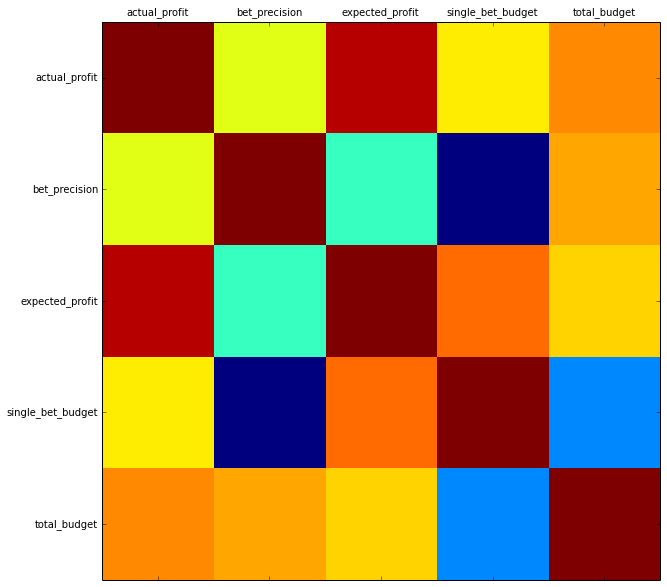

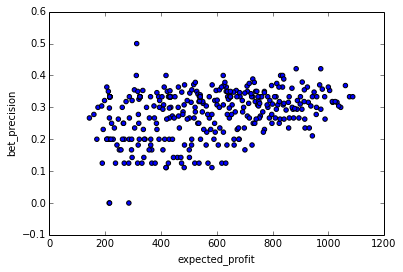

In [198]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 300]
betting_tracker_copy.hist(column=['actual_profit', 'bet_precision'], bins = 50, figsize = (12, 4))
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)
betting_tracker_copy.plot(x='expected_profit', y='bet_precision', kind='scatter')

1.0
                   actual_profit  bet_precision  expected_profit  \
actual_profit           1.000000       0.521213         0.969820   
bet_precision           0.521213       1.000000         0.320682   
expected_profit         0.969820       0.320682         1.000000   
single_bet_budget       0.670698      -0.222681         0.807038   
total_budget            0.543043       0.600085         0.447334   

                   single_bet_budget  total_budget  
actual_profit               0.670698      0.543043  
bet_precision              -0.222681      0.600085  
expected_profit             0.807038      0.447334  
single_bet_budget           1.000000      0.000000  
total_budget                0.000000      1.000000  


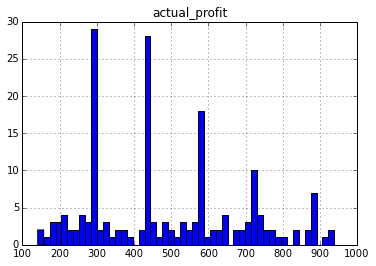

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


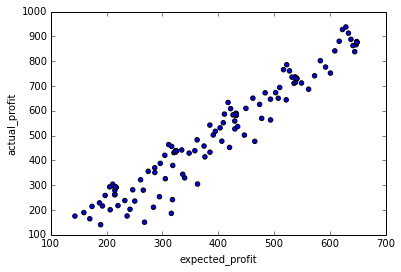

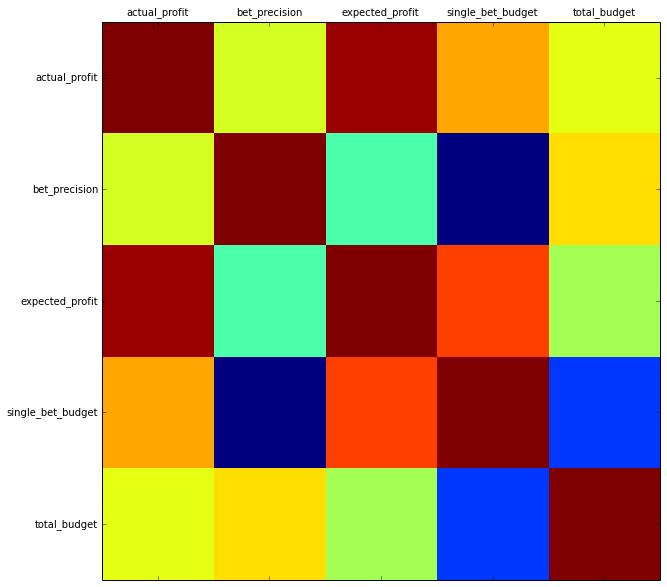

In [199]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 150]
betting_tracker_copy.hist(column='actual_profit', bins = 50)
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)

In [200]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : [], 'bet_precision' : []}
data = pd.read_csv('../../../data/third_party_preds/baidu-121115.csv')
for total_budget in np.arange(100, 3000, 100):
    for single_bet_budget in np.arange(50, 3000, 50):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit, bet_precision = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)
        result_dict['bet_precision'].append(np.mean(np.array(list(bet_precision.values()))))

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
0,30.468292,0.166667,100.830458,50,100
1,-43.366484,0.125000,116.092884,100,100
2,-99.865634,0.000000,133.121296,150,100
3,-99.891267,0.000000,129.948062,200,100
4,-99.690476,0.000000,119.524329,250,100


In [201]:
betting_tracker.ix[betting_tracker.idxmax(), :]

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
1691,2316.458208,0.285714,3206.466114,2000,2900
895,1304.010500,0.368421,1330.215780,550,1600
1707,851.841492,0.200000,3502.667226,2800,2900
58,-99.818648,0.000000,10.313104,2950,100
1652,97.303347,0.224138,137.654092,50,2900


0.815517241379
                   actual_profit  bet_precision  expected_profit  \
actual_profit           1.000000       0.829627         0.751250   
bet_precision           0.829627       1.000000         0.461682   
expected_profit         0.751250       0.461682         1.000000   
single_bet_budget       0.163314      -0.221224         0.676929   
total_budget            0.726430       0.643785         0.575166   

                   single_bet_budget  total_budget  
actual_profit               0.163314      0.726430  
bet_precision              -0.221224      0.643785  
expected_profit             0.676929      0.575166  
single_bet_budget           1.000000      0.000000  
total_budget                0.000000      1.000000  


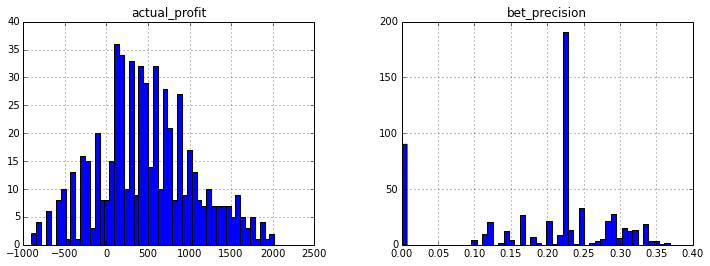

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


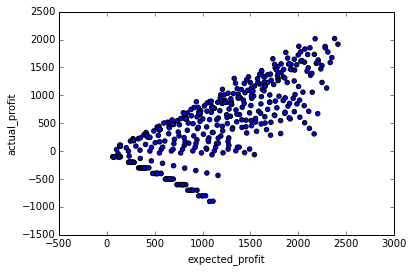

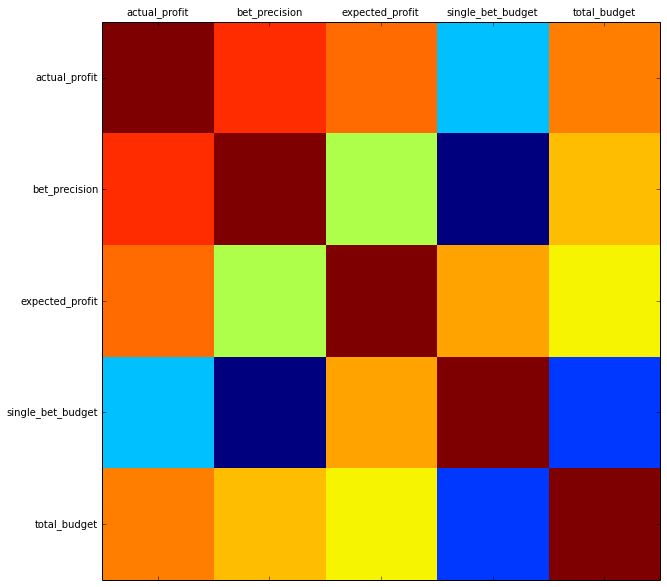

In [202]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 1000]
betting_tracker_copy.hist(column=['actual_profit', 'bet_precision'], bins = 50, figsize = (12, 4))
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)

In [203]:

data = pd.read_csv('../../../data/third_party_preds/betegy-121615.csv')
premier = data.ix[0:9, :]
bundesliga = data.ix[10:18, :]
bundesliga.set_index([[i for i in np.arange(0, bundesliga.shape[0])]], inplace=True)
france = data.ix[19:27, :]
france.set_index([[i for i in np.arange(0, france.shape[0])]], inplace=True)
laliga = data.ix[28:36, :]
laliga.set_index([[i for i in np.arange(0, laliga.shape[0])]], inplace=True)
seriea = data.ix[37:, :]
seriea.set_index([[i for i in np.arange(0, seriea.shape[0])]], inplace=True)
bundesliga.ix[5, 'result'] = 2
bundesliga

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Home vs Away,Home Win,Home Draw,Home Lost,b365H,b365D,b365A,bwinH,bwinD,bwinA,result
0,Schalke 04 vs Hoffenheim,0.41,0.31,0.28,1.66,3.80,5.00,1.75,3.60,4.50,1
1,Hannover 96 vs Bayern,0.19,0.26,0.55,17.00,7.50,1.14,13.00,7.00,1.18,3
2,Koln vs Dortmund,0.21,0.27,0.52,6.50,5.00,1.40,6.00,4.70,1.45,1
3,Frankfurt vs Werder,0.27,0.31,0.42,2.10,3.60,3.20,2.05,3.30,3.60,1
4,Hamburg vs Augsburg,0.31,0.32,0.37,2.25,3.25,3.25,2.00,3.30,3.75,3
5,Ingolstadt vs Leverkusen,0.33,0.33,0.34,4.33,3.60,1.80,4.50,3.60,1.75,2
6,Stuttgart vs Wolfsburg,0.29,0.32,0.39,3.00,3.50,2.25,3.00,3.30,2.15,1
7,Hertha vs Mainz 05,0.39,0.32,0.29,2.20,3.25,3.30,2.10,3.30,3.40,1
8,Borussia MG vs Darmstadt 98,0.47,0.29,0.24,1.44,4.33,7.00,1.45,4.75,6.00,1


In [204]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : [], 'bet_precision' : []}
for total_budget in np.arange(100, 1000, 25):
    for single_bet_budget in np.arange(50, 350, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, seriea, list_of_bookmakers)
        actual_profit, bet_precision = get_actual_profit(actual_bets, seriea, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)
        result_dict['bet_precision'].append(np.mean(np.array(list(bet_precision.values()))))

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
0,-37.482062,0.166667,54.195093,50,100
1,-5.589847,0.222222,62.647675,75,100
2,25.611013,0.250000,68.352597,100,100
3,-99.880435,0.000000,74.313324,125,100
4,-5.650000,0.250000,73.341500,150,100


In [205]:
betting_tracker.ix[betting_tracker.idxmax(), :]

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
119,83.235793,0.250000,222.145941,325,325
22,62.586957,0.333333,93.650978,300,125
431,-568.720287,0.090909,438.799254,325,975
11,-98.523290,0.000000,81.292699,325,100
420,-108.647445,0.058824,70.022517,50,975


In [206]:
total_budget = 1000
single_bet_budget = 300
expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, bundesliga, list_of_bookmakers)
actual_profit, bet_precision = get_actual_profit(actual_bets, bundesliga, bookmaker_row_vector)
actual_profit, bet_precision, np.mean(np.array(list(bet_precision.values()))), actual_bets

(-182.10866666138406,
 {'Borussia MG vs Darmstadt 98,Home Draw,b365': 0,
  'Borussia MG vs Darmstadt 98,Home Draw,bwin': 0,
  'Borussia MG vs Darmstadt 98,Home Lost,b365': 0,
  'Borussia MG vs Darmstadt 98,Home Lost,bwin': 0,
  'Frankfurt vs Werder,Home Draw,b365': 0,
  'Frankfurt vs Werder,Home Draw,bwin': 0,
  'Frankfurt vs Werder,Home Lost,b365': 0,
  'Frankfurt vs Werder,Home Lost,bwin': 0,
  'Hamburg vs Augsburg,Home Draw,b365': 0,
  'Hamburg vs Augsburg,Home Draw,bwin': 0,
  'Hamburg vs Augsburg,Home Lost,b365': 1,
  'Hamburg vs Augsburg,Home Lost,bwin': 1,
  'Hannover 96 vs Bayern,Home Draw,b365': 0,
  'Hannover 96 vs Bayern,Home Draw,bwin': 0,
  'Hannover 96 vs Bayern,Home Win,b365': 0,
  'Hannover 96 vs Bayern,Home Win,bwin': 0,
  'Hertha vs Mainz 05,Home Draw,b365': 0,
  'Hertha vs Mainz 05,Home Draw,bwin': 0,
  'Ingolstadt vs Leverkusen,Home Draw,b365': 1,
  'Ingolstadt vs Leverkusen,Home Draw,bwin': 1,
  'Ingolstadt vs Leverkusen,Home Win,b365': 0,
  'Ingolstadt vs Leverkus

0.0656565656566
(396, 5)
                   actual_profit  bet_precision  expected_profit  \
actual_profit           1.000000       0.536067        -0.732900   
bet_precision           0.536067       1.000000         0.086231   
expected_profit        -0.732900       0.086231         1.000000   
single_bet_budget      -0.253676       0.348612         0.749507   
total_budget           -0.751492      -0.446512         0.504880   

                   single_bet_budget  total_budget  
actual_profit              -0.253676     -0.751492  
bet_precision               0.348612     -0.446512  
expected_profit             0.749507      0.504880  
single_bet_budget           1.000000      0.000000  
total_budget                0.000000      1.000000  


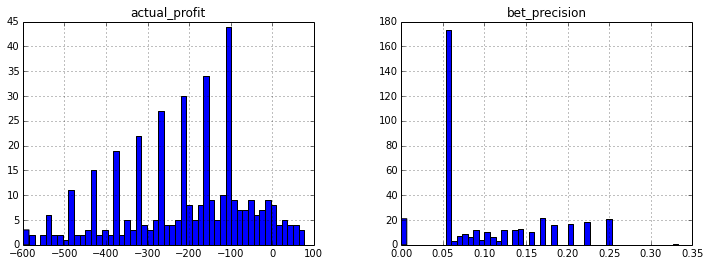

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


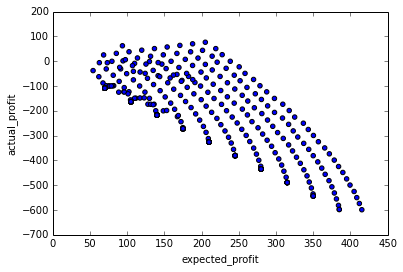

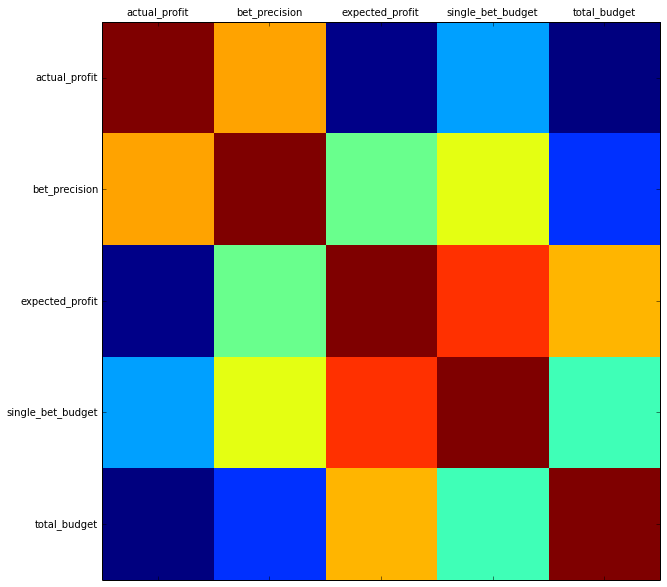

In [207]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 300]
betting_tracker_copy.hist(column=['actual_profit', 'bet_precision'], bins = 50, figsize = (12, 4))
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
print(betting_tracker_copy.shape)
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)

In [208]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : [], 'bet_precision' : []}
data = pd.read_csv('../../../data/third_party_preds/baidu-121615.csv')
for total_budget in np.arange(100, 3000, 100):
    for single_bet_budget in np.arange(50, 3000, 25):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit, bet_precision = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)
        result_dict['bet_precision'].append(np.mean(np.array(list(bet_precision.values()))))

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
0,39.736833,0.222222,4.604894,50,100
1,59.605250,0.222222,6.907341,75,100
2,79.473667,0.222222,9.209788,100,100
3,112.336379,0.322581,11.336088,125,100
4,144.167606,0.421053,12.827925,150,100


In [209]:
total_budget = 100
single_bet_budget = 1000
expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
actual_profit, bet_precision = get_actual_profit(actual_bets, data, bookmaker_row_vector)
actual_profit, bet_precision, np.mean(np.array(list(bet_precision.values()))), actual_bets

(623.81666666666672,
 {'Chelsea vs Sunderland,Home Lost,b365': 0,
  'Hannover 96 vs Bayern,Home Win,b365': 0,
  'Man United vs Norwich City,Home Lost,b365': 1,
  'Real Madrid vs Rayo,Home Lost,b365': 0,
  'Watford vs Liverpool,Home Win,b365': 1},
 0.40000000000000002,
 {'Arsenal vs Man City,Home Draw,b365': -0.0,
  'Arsenal vs Man City,Home Draw,bwin': -0.0,
  'Arsenal vs Man City,Home Lost,b365': 0.0,
  'Arsenal vs Man City,Home Lost,bwin': -0.0,
  'Arsenal vs Man City,Home Win,b365': -0.0,
  'Arsenal vs Man City,Home Win,bwin': -0.0,
  'Atalanta vs Napoli,Home Draw,b365': -0.0,
  'Atalanta vs Napoli,Home Draw,bwin': -0.0,
  'Atalanta vs Napoli,Home Lost,b365': -0.0,
  'Atalanta vs Napoli,Home Lost,bwin': -0.0,
  'Atalanta vs Napoli,Home Win,b365': -0.0,
  'Atalanta vs Napoli,Home Win,bwin': -0.0,
  'Athletic vs Levante,Home Draw,b365': -0.0,
  'Athletic vs Levante,Home Draw,bwin': -0.0,
  'Athletic vs Levante,Home Lost,b365': -0.0,
  'Athletic vs Levante,Home Lost,bwin': -0.0,
  'Ath

1.0
(1131, 5)
                   actual_profit  bet_precision  expected_profit  \
actual_profit           1.000000       0.310608         0.924709   
bet_precision           0.310608       1.000000        -0.038349   
expected_profit         0.924709      -0.038349         1.000000   
single_bet_budget       0.988367       0.219382         0.946276   
total_budget           -0.054748      -0.515031         0.143943   

                   single_bet_budget  total_budget  
actual_profit               0.988367     -0.054748  
bet_precision               0.219382     -0.515031  
expected_profit             0.946276      0.143943  
single_bet_budget           1.000000      0.000000  
total_budget                0.000000      1.000000  


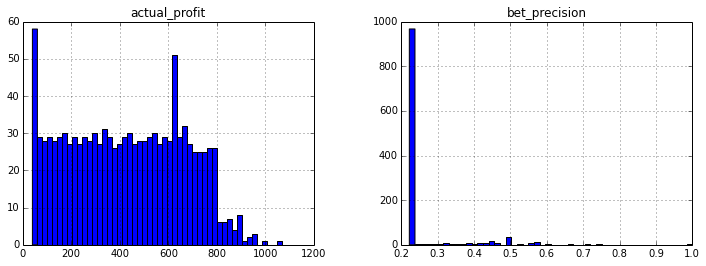

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


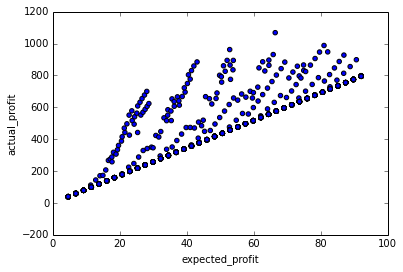

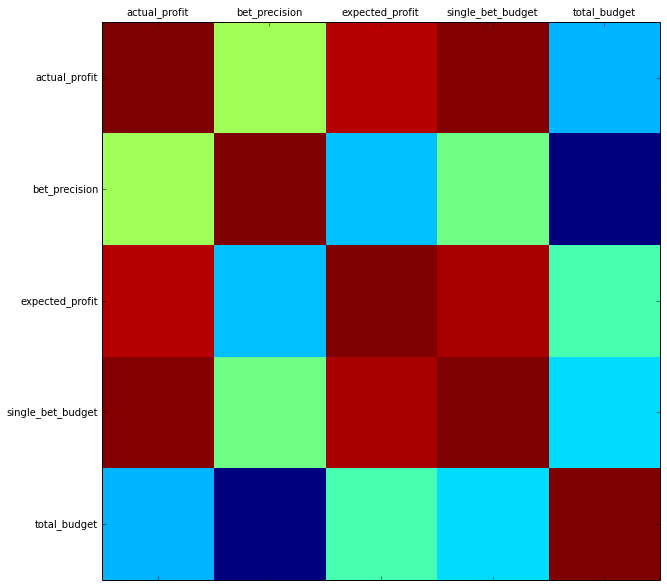

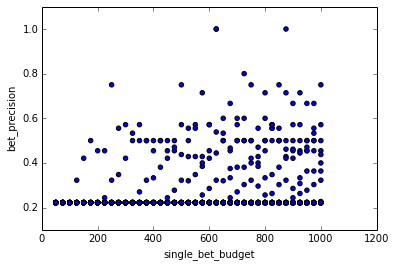

In [210]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 1000]
betting_tracker_copy.hist(column=['actual_profit', 'bet_precision'], bins = 50, figsize = (12, 4))
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
print(betting_tracker_copy.shape)
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)
betting_tracker_copy.plot(x='single_bet_budget', y='bet_precision', kind='scatter')

In [211]:

data = pd.read_csv('../../../data/third_party_preds/baidu-120415.csv')
data['Home vs Away'] = data['Home'] + ' vs ' + data['Away']
data.head()

,Div,Home,Away,Home Win,Home Draw,Home Lost,b365H,b365D,b365A,bwinH,bwinD,bwinA,result,Home vs Away
0,E0,Arsenal,Sunderland,0.74,0.18,0.08,1.29,6.00,13.0,1.26,6.25,10.50,1,Arsenal vs Sunderland
1,E0,Chelsea,Bournemouth,0.70,0.20,0.10,1.36,5.25,9.5,1.38,5.00,8.00,3,Chelsea vs Bournemouth
2,E0,Man United,West Ham,0.66,0.23,0.11,1.44,4.50,9.0,1.44,4.33,8.00,2,Man United vs West Ham
3,E0,Southampton,Aston Villa,0.63,0.24,0.13,1.50,4.50,7.5,1.50,4.25,6.00,2,Southampton vs Aston Villa
4,E0,Stoke,Man City,0.19,0.26,0.55,5.25,4.00,1.7,5.00,3.70,1.72,1,Stoke vs Man City


In [212]:
result_dict = {'total_budget' : [], 'single_bet_budget' : [], 'expected_profit' : [], 'actual_profit' : [], 'bet_precision' : []}
for total_budget in np.arange(100, 3000, 100):
    for single_bet_budget in np.arange(50, 3000, 100):
        expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
        actual_profit, bet_precision = get_actual_profit(actual_bets, data, bookmaker_row_vector)
        result_dict['total_budget'].append(total_budget)
        result_dict['single_bet_budget'].append(single_bet_budget)
        result_dict['expected_profit'].append(expected_profit)
        result_dict['actual_profit'].append(actual_profit)
        result_dict['bet_precision'].append(np.mean(np.array(list(bet_precision.values()))))

betting_tracker = pd.DataFrame(result_dict)
betting_tracker.head()

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
0,6.972816,0.375000,1.198010,50,100
1,20.918448,0.375000,3.594031,150,100
2,34.864080,0.375000,5.990051,250,100
3,28.408954,0.277778,7.904178,350,100
4,21.183096,0.230769,8.954349,450,100


0.996551724138
(290, 5)
                   actual_profit  bet_precision  expected_profit  \
actual_profit           1.000000       0.170571         0.978745   
bet_precision           0.170571       1.000000        -0.022941   
expected_profit         0.978745      -0.022941         1.000000   
single_bet_budget       0.944247      -0.136086         0.988387   
total_budget            0.099372       0.305737         0.040114   

                   single_bet_budget  total_budget  
actual_profit               0.944247      0.099372  
bet_precision              -0.136086      0.305737  
expected_profit             0.988387      0.040114  
single_bet_budget           1.000000      0.000000  
total_budget                0.000000      1.000000  


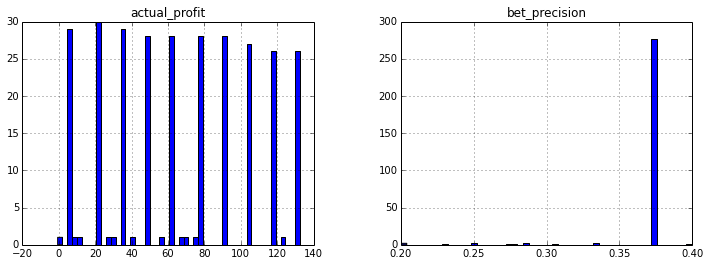

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


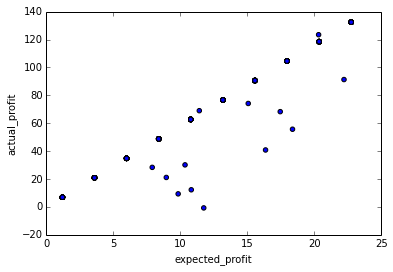

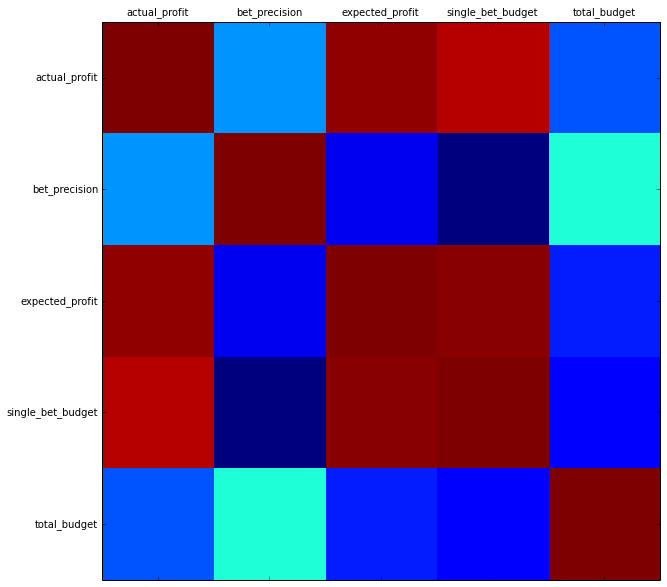

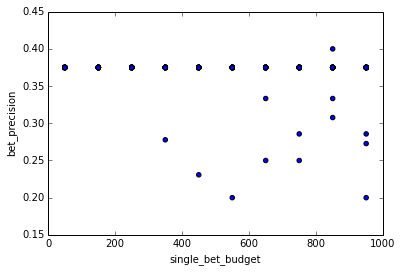

In [213]:
betting_tracker_copy = betting_tracker.copy()
betting_tracker_copy = betting_tracker_copy[betting_tracker_copy['single_bet_budget'] <= 1000]
betting_tracker_copy.hist(column=['actual_profit', 'bet_precision'], bins = 50, figsize = (12, 4))
print(np.mean(betting_tracker_copy['actual_profit'] > 0))
print(betting_tracker_copy.shape)
betting_tracker_copy.plot(x='expected_profit', y='actual_profit', kind='scatter')
plot_corr(betting_tracker_copy)
betting_tracker_copy.plot(x='single_bet_budget', y='bet_precision', kind='scatter')

In [214]:
betting_tracker.ix[betting_tracker.idxmax(), :]

,actual_profit,bet_precision,expected_profit,single_bet_budget,total_budget
329,411.396144,0.375,70.682607,2950,1100
22,132.750000,0.500,14.036786,2250,100
329,411.396144,0.375,70.682607,2950,1100
29,-94.727778,0.000,16.287278,2950,100
840,6.972816,0.375,1.198010,50,2900


In [215]:
total_budget = 1100
single_bet_budget = 2950
expected_profit, actual_bets, kellies, bookmaker_row_vector, prob_row_vector = solve(total_budget, single_bet_budget, data, list_of_bookmakers)
actual_profit, bet_precision = get_actual_profit(actual_bets, data, bookmaker_row_vector)
actual_profit, bet_precision, np.mean(np.array(list(bet_precision.values()))), actual_bets, kellies

(411.39614354443165,
 {'Arsenal vs Sunderland,Home Draw,b365': 0,
  'Arsenal vs Sunderland,Home Draw,bwin': 0,
  'Arsenal vs Sunderland,Home Lost,b365': 0,
  'Ath Bilbao vs Malaga,Home Draw,b365': 1,
  'Bastia vs Monaco,Home Draw,b365': 0,
  'Bologna vs Napoli,Home Win,b365': 1,
  'Bordeaux vs Guingamp,Home Lost,b365': 0,
  'Carpi vs Milan,Home Draw,b365': 1,
  'Carpi vs Milan,Home Draw,bwin': 1,
  'Chelsea vs Bournemouth,Home Draw,b365': 0,
  'Espanol vs Levante,Home Draw,b365': 1,
  'Everton vs Crystal Palace,Home Draw,b365': 1,
  'Fiorentina vs Udinese,Home Draw,b365': 0,
  'Granada vs Ath Madrid,Home Draw,b365': 0,
  'Granada vs Ath Madrid,Home Draw,bwin': 0,
  'Lazio vs Juventus,Home Draw,b365': 0,
  'Lazio vs Juventus,Home Draw,bwin': 0,
  'Man United vs West Ham,Home Draw,b365': 1,
  'Newcastle vs Liverpool,Home Draw,b365': 0,
  'Real Madrid vs Getafe,Home Draw,b365': 0,
  'Real Madrid vs Getafe,Home Draw,bwin': 0,
  'Reims vs Troyes,Home Draw,b365': 1,
  'Reims vs Troyes,Home L